Thanks to: <br>
https://github.com/soumyac1999/FGSM-Keras, <br>
           https://github.com/YunYang1994/TensorFlow2.0-Examples, <br>
           https://www.tensorflow.org/beta/tutorials/generative/adversarial_fgsm

##  Iterative Least Likely Class Method

In [1]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import cv2

## importing an image

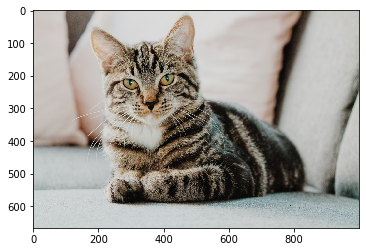

In [2]:
im = cv2.imread("cat.jpeg")
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)  
plt.imshow(im)
plt.show()

## preprosessing the image:

In [3]:
im = cv2.resize(im, dsize=(224,224))
image = tf.keras.applications.mobilenet_v2.preprocess_input(im)
expanded_image = np.expand_dims(image, axis=0) # needed to be inputted to the model

## Importing Mobilenet model on imagenet dataset:

In [4]:
model = tf.keras.applications.mobilenet_v2.MobileNetV2(weights='imagenet')

## Finding out the label of the image:

In [5]:
labels = model.predict(expanded_image)
print(tf.keras.applications.mobilenet_v2.decode_predictions(labels,top=3)[0])

[('n02123159', 'tiger_cat', 0.5283619), ('n02123045', 'tabby', 0.36492294), ('n02124075', 'Egyptian_cat', 0.017658347)]


## Choosing the least likely predicted class as the label, building the corresponding one-hot vector:

In [6]:
least_label_onehot = np.eye(1000)[labels.argmin()].astype(np.float32).reshape(-1,1000)

## Calculating the gradient with respect to the image:

In [7]:
tensor_real_image = tf.convert_to_tensor(expanded_image) # input of tf.GradientTape must be a tensor

#least_likely_label_onehot = np.eye(1000)[tf.math.argmin(prediction)].astype(np.float32).reshape(-1,1000)

number_of_iterations = 10

tensor_adv_image = tensor_real_image

for i in range(number_of_iterations):
    with tf.GradientTape() as tape:
        tape.watch(tensor_adv_image)
        prediction = model(tensor_adv_image) 
        loss = tf.keras.losses.categorical_crossentropy(least_label_onehot, prediction)

    gradients = tape.gradient(loss, tensor_adv_image) # automatic derivate of loss w.r.t. the input
    np_gradients = gradients.numpy() 
    np_gradients_signed = np.sign(np_gradients)
    alpha = 1  # as in Adversarial MAchine Learning At Scale, Goodfellow et al.
    np_gradients_signed *= 1
    epsilon = 0.1
    tensor_adv_image = tf.clip_by_value(tensor_adv_image - np_gradients_signed,
                                 expanded_image-epsilon, expanded_image+epsilon)


W0714 11:28:27.488914 4553528768 deprecation.py:323] From /Users/john/anaconda3/envs/tf2/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1220: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


# Real Image prediction results:

In [8]:
y = model.predict(expanded_image)
print(tf.keras.applications.mobilenet_v2.decode_predictions(y,
      top=3)[0])

[('n02123159', 'tiger_cat', 0.5283619), ('n02123045', 'tabby', 0.36492294), ('n02124075', 'Egyptian_cat', 0.017658347)]


# new image prediction results:

In [9]:
y = model.predict(tensor_adv_image)
print(tf.keras.applications.mobilenet_v2.decode_predictions(y,
      top=3)[0])

[('n02123045', 'tabby', 0.6615858), ('n02123159', 'tiger_cat', 0.28575027), ('n02124075', 'Egyptian_cat', 0.004937063)]


## Drawing images:

In [10]:
intact = expanded_image
adv = tensor_adv_image.numpy()
gra = intact - adv
# resacaling to 0 .. 255 
i = np.interp(intact, (intact.min(), intact.max()), (0, 255)).astype(np.int)
a = np.interp(adv, (adv.min(), adv.max()), (0, 255)).astype(np.int)
g = np.interp(gra, (gra.min(), gra.max()),(0,255)).astype(np.int)
ii = np.squeeze(i)
aa = np.squeeze(a)
gg = np.squeeze(g)

# Real Image

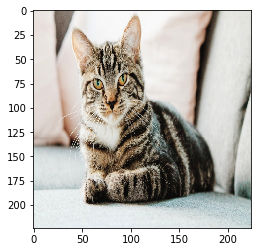

In [11]:
plt.imshow(ii)
plt.show()

# Attacked image

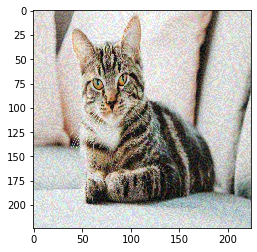

In [12]:
plt.imshow(aa)
plt.show()

# Noise added:

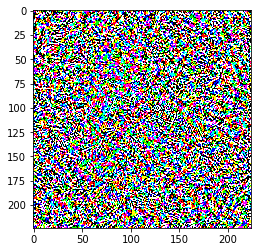

In [13]:
plt.imshow(gg)
plt.show()